# Preprocessing

In [3]:
import numpy as np
import spacy
import gensim
import os
import re
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd
nlp = spacy.load("en_core_web_lg")

C:\Users\tally\.virtualenvs\Repositories-J01Zxu1S\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
from bs4 import BeautifulSoup
from os import mkdir
import requests
#Dicitionary used to access full book text in HTML format
urls = {'foucault_madness_and_civ':'https://archive.org/stream/Michel_Foucault_Madness_And_Civilization/Michel%20Foucault%2C%20Richard%20Howard%20%28transl.%29%20-%20Madness%20and%20Civilization_%20A%20History%20of%20Insanity%20in%20the%20Age%20of%20Reason%20%282013%2C%20Vintage%29_djvu.txt',
        'foucault_history_of_sexuality':'https://archive.org/stream/TheHistoryOfSexualityVol13/The-History-Of-Sexuality-Vol-1-3_djvu.txt',
        'chomsky_american_power': 'https://archive.org/stream/AmericanPowerAndTheNewMandarins_201805/American%20Power%20And%20The%20New%20Mandarins_djvu.txt',
        'chomsky_manufacturing_consent': 'https://archive.org/stream/revhosatx14/%5BEdward_S._Herman%2C_Noam_Chomsky%5D_Manufacturing_Con%28b-ok.org%29_djvu.txt'}

In [5]:
def file_books(title, link):
    '''Create directories for book from title and link'''
    #Access HTML webpage on Internet Archive
    r = requests.get(link)
    data = r.text
    soup = BeautifulSoup(data)
    #Full text is in <pre> part of HTML doc
    book = soup.pre.string
    #Write book as text file, save file
    with open(f'./data/{title}.txt', 'w', encoding='utf-8') as book_file:
        book_file.write(book)
        #Make a folder for each book
        mkdir(f'./data/{title}_extracts')
def split_book(title, n_lines=100):
    '''Split a text file based on a number of lines, book title'''
    #Find file path based on title
    filepath = f'./data/{title}.txt'
    #Extract directory and filename from file path
    path, filename = os.path.split(filepath)
    #Change path to book's directory
    path += f'/{title}_extracts'
    # filename.split('.') would not work for filenames with more than one .
    basename, ext = os.path.splitext(filename)
    #open input file
    with open(filepath, 'r', encoding='utf-8') as book_file:
        try:
            #open the first output(extract) file
            extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, 0, ext)), 'w', encoding='utf-8')
            #Loop over all lines of input file, number them
            for i, line in enumerate(book_file):
                #Close extract file and open a new one
                #When the line number % desired n_lines is 0
                if i % n_lines == 0:
                    extract_file.close()
                    #Open the next output file to write the next extract
                    extract_file = open(os.path.join(path, '{}_{}{}'.format(basename, i/100, ext)), 'w', encoding='utf-8')
                #write the line to extract file
                extract_file.write(line)
        finally:
            #close last output file
            extract_file.close()

In [6]:
if not os.path.isdir('./data'):  
    os.mkdir('./data')
    for title, link in urls.items():
        file_books(title, link)
        split_book(title)

In [7]:
def tokenize(doc):
    '''Tokenizer with lemmatizer'''
    return [token.lemma_ for token in nlp(doc) if (token.is_stop == False) &
            (token.is_punct == False) & (token.is_space == False) &
            (token.is_upper == False) & (token.pos_ != 'PROPN')]
def gather_data(path_to_data):
    path = f'./data/{path_to_data}'
    data = {'extracts': [], 'author': []}
    #For file at the given path
    for file in os.listdir(path):
        #If the directory is not a folder
        if os.path.isdir(file) == False:
            #If the file type is .txt
            if file[-3:] == 'txt':
                #Open each text file at the path provided
                with open(os.path.join(path, file), encoding='utf-8') as t:
                    #Read and strip new line signal
                    text = t.read().replace('\n', ' ')
                    data['extracts'].append(str(text))
                    data['author'].append(path_to_data.split('_')[0])
    return data

In [8]:
tokenize('If you should ever leave me, Jack your LIFE would still go on believe me')      

['leave', 'believe']

In [9]:
extracts_dirs = [folder for folder in os.listdir('./data') if (os.path.isdir(f'./data/{folder}') == True)]

In [10]:
df_final = pd.DataFrame({'extracts': [], 'author': []})
for directory in extracts_dirs:
    extracts = gather_data(directory)
    df = pd.DataFrame(extracts, columns = extracts.keys())
    df_final = pd.concat([df_final, df], axis=0)
#     print(extracts['author'])
#     print(directory)
print(df_final.shape)
df_final = df_final.reset_index()

(898, 2)


# Model

## Train/Test Split

In [11]:
import imblearn

In [12]:
from sklearn.model_selection import train_test_split
X = df_final['extracts']
y = df_final['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## Randomized Search w/ Random Forest

In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
counter = TfidfVectorizer(
#     max_df = .97,
#                           min_df = 5,
#                           stop_words='english',
# #                           ngram_range= (1,3),
                          tokenizer=tokenize)

rf = BalancedRandomForestClassifier()

In [15]:
pipeline = Pipeline([('counter', counter),
                     ('rf', rf)])
parameters = {
    'counter__max_df': [i/100 for i in range(75, 100)],
    'counter__min_df': range(0, 10),
    'counter__ngram_range': [(1,2), (1, 3), (2,3), (3, 6), (2, 7)],
    'counter__analyzer': ['word', 'char', 'char_wb'],
    'rf__max_depth': range(5,20),
    'rf__min_samples_split': range(2, 10),
    'rf__min_samples_leaf': range(1,50)
}

rand_search = RandomizedSearchCV(pipeline, parameters, cv=2, n_iter=3, n_jobs=1, verbose=2)

In [16]:
best = rand_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] rf__min_samples_split=5, rf__min_samples_leaf=34, rf__max_depth=6, counter__ngram_range=(1, 3), counter__min_df=3, counter__max_df=0.84, counter__analyzer=char 
[CV]  rf__min_samples_split=5, rf__min_samples_leaf=34, rf__max_depth=6, counter__ngram_range=(1, 3), counter__min_df=3, counter__max_df=0.84, counter__analyzer=char, total=   7.3s
[CV] rf__min_samples_split=5, rf__min_samples_leaf=34, rf__max_depth=6, counter__ngram_range=(1, 3), counter__min_df=3, counter__max_df=0.84, counter__analyzer=char 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  rf__min_samples_split=5, rf__min_samples_leaf=34, rf__max_depth=6, counter__ngram_range=(1, 3), counter__min_df=3, counter__max_df=0.84, counter__analyzer=char, total=   7.8s
[CV] rf__min_samples_split=2, rf__min_samples_leaf=7, rf__max_depth=6, counter__ngram_range=(2, 7), counter__min_df=2, counter__max_df=0.89, counter__analyzer=char_wb 
[CV]  rf__min_samples_split=2, rf__min_samples_leaf=7, rf__max_depth=6, counter__ngram_range=(2, 7), counter__min_df=2, counter__max_df=0.89, counter__analyzer=char_wb, total=  25.8s
[CV] rf__min_samples_split=2, rf__min_samples_leaf=7, rf__max_depth=6, counter__ngram_range=(2, 7), counter__min_df=2, counter__max_df=0.89, counter__analyzer=char_wb 
[CV]  rf__min_samples_split=2, rf__min_samples_leaf=7, rf__max_depth=6, counter__ngram_range=(2, 7), counter__min_df=2, counter__max_df=0.89, counter__analyzer=char_wb, total=  24.5s
[CV] rf__min_samples_split=7, rf__min_samples_leaf=5, rf__max_depth=10, counter__ngram_range=(3, 6), counter__min_df=

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min finished


In [17]:
best.best_estimator_.score(X_val, y_val)

0.9876543209876543

In [18]:
best.best_estimator_.predict_proba([''])

array([[0.30056396, 0.69943604]])

In [ ]:
import pickle 
filename = '5_liners_change_analyzer.sav'
pickle.dump(best, open(filename, 'wb'))

## Nearest Neighbors Classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [206]:
counter = TfidfVectorizer(
    max_df = .97,
                          min_df = 5,
                          stop_words='english',
                          ngram_range= (1,3),
                          tokenizer=tokenize)

In [207]:
counts_train = counter.fit_transform(X_train).todense()
counts_val = counter.transform(X_val).todense()

In [211]:
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=1)
knn.fit(counts_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [212]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(counts_val)
accuracy_score(y_val, y_pred)

0.5493615696044846

In [16]:
from sklearn.metrics import roc_auc_score
y_pred = best.best_estimator_.predict(X_val)

# Word Embeddings with Spacy

In [189]:
def get_doc_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

In [156]:
pca = PCA(2)
word_vecs_2d = pca.fit_transform(get_doc_vectors(df_final['extracts']))

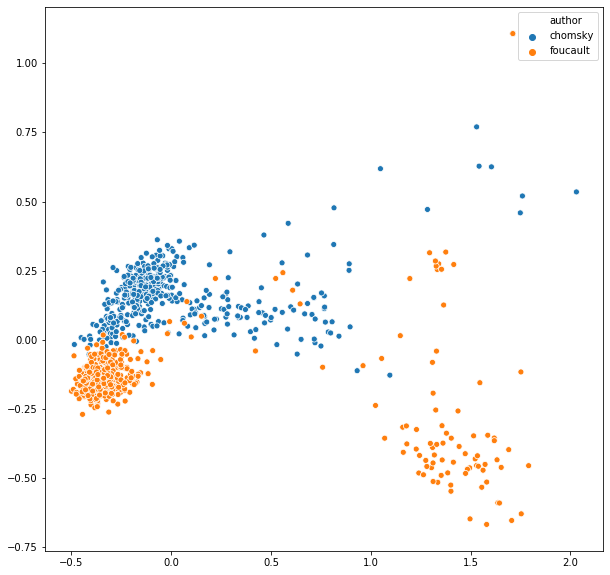

In [163]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.scatterplot(word_vecs_2d[:,0], word_vecs_2d[:,1], hue=df_final['author'])
plt.title('')

# Word Embeddings w/ Gensim

In [ ]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

In [137]:
def read_corpus(series, tokens_only=False):
    for i, doc in enumerate(series):
        tokens = gensim.utils.simple_preprocess(doc)
        print(tokens)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [149]:
next(read_corpus(df_final['extracts']))

['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii']


TaggedDocument(words=['rl', 'if', 'kjii', 'jp', 'kwsg', 'ffc', 'fffjil', 'ri', 'hscif', 'piini', 'pqb', 'ffi', 'ipil', 'igij', 'ssbhlil', 'ps', 'im', 'iilb', 'ii', 'msjr', 'tashi', 'nst', 'liii', 'sf', 'ic', 'tta', 'ksp', 'mr', 'izlv', 'siirhki', 'hhh', 'fjfi', 'imimmiumnmum', 'mm', 'ar', 'kttaskni', 'ks', 'ssi', 'sr', 'ziubuss', 'fmhlll', 'fiiblii', 'hi', 'hr', 'hhi', 'rwm', 'tret', 'sks', 'nh', 'ii'], tags=[0])